# Alchemical transformation example
This example shows how to transform ethylene to chloroform using the Alchemistry module of peleffy.

## Initialize both molecules
The alchemical transformation requires the end states to be previously defined. We can initialize both molecules with peleffy with the standard `Molecule` representation. In this case, we define them using SMILES notation. However, we can also initialize them from PDB files.

In [1]:
from peleffy.topology import Molecule

In [2]:
ethylene = Molecule(smiles='C=C', hydrogens_are_explicit=False,
                    name='ethylene', tag='ETH')

 - Initializing molecule from a SMILES tag
   - Loading molecule from RDKit
   - Representing molecule with the Open Force Field Toolkit
 - Generating rotamer library
   - Core set to the center of the molecule


In [3]:
chloroform = Molecule(smiles='ClC(Cl)Cl', hydrogens_are_explicit=False,
                      name='chloroform', tag='CHL')

 - Initializing molecule from a SMILES tag
   - Loading molecule from RDKit
   - Representing molecule with the Open Force Field Toolkit
 - Generating rotamer library
   - Core set to the center of the molecule


Once they are loaded, we can check if they were properly defined:

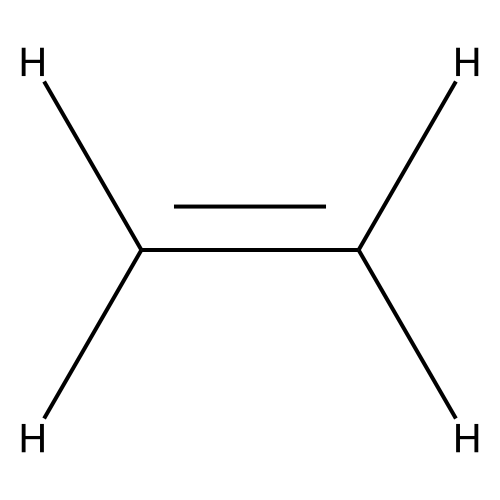

In [4]:
display(ethylene)

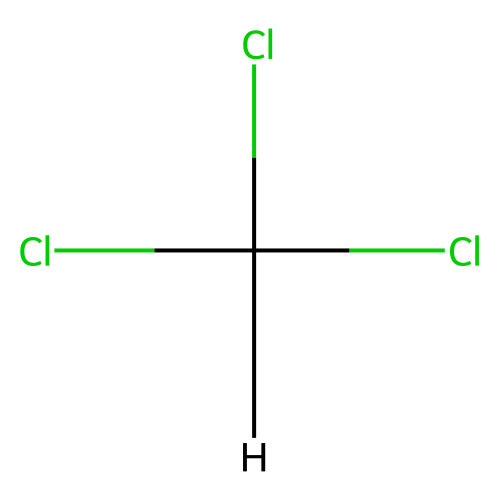

In [5]:
display(chloroform)

## Parametrization and topology generation
The next step is to obtain the parameters and the topology for both molecules. This procedure can be done using peleffy's regular methods.

In [6]:
from peleffy.forcefield import OpenForceField
from peleffy.topology import Topology

In [7]:
openff = OpenForceField('openff_unconstrained-2.0.0.offxml')

In [8]:
ethylene_params = openff.parameterize(ethylene)

In [9]:
chloroform_params = openff.parameterize(chloroform)

In [10]:
ethylene_top = Topology(ethylene, ethylene_params)

In [11]:
chloroform_top = Topology(chloroform, chloroform_params)

## Alchemical transformation
Once we get the topology of both end states, we can initialize the `Alchemizer` module which will be able to generate the intermediate states according to the lambda values we supply.

In [12]:
from peleffy.topology import Alchemizer

In [13]:
alchemizer = Alchemizer(ethylene_top, chloroform_top)

When `Alchemizer` is initialized, it tries to pair as many atom as possible between both end states, considering the Maximum Common Substructure (MCS). We can check this pairing:

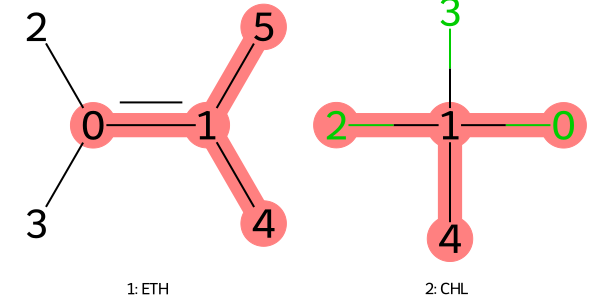

In [14]:
display(alchemizer)

We can save end states and their hybrid structure to a PDB file. All PDB structures will be aligned according to the MCS to facilitate their comparison. The hybrid structure is the one that needs to be used in the PELE simulation since it contains all the required atoms to go from ethylene (state 1) to chloroform (state 2).

In [15]:
alchemizer.molecule1_to_pdb('state1.pdb')
alchemizer.molecule2_to_pdb('state2.pdb')
alchemizer.hybrid_to_pdb('hybrid.pdb')

We can generate Impact templates with the `get_alchemical_topology()` method. It assigns the parameters to the hybrid structure according to the lambda value that we supply. Lambda values need to be contained between 0 and 1. A lambda of 0 represent state 1, a lambda of 1 represents state 2 and any value in between will be used to interpolate the parameters of each end state. There are different types of lambdas depending on the subset of parameters they modify:
- `fep_lambda`: it affects all the parameters.
- `coul_lambda`: it only affects coulombic parameters of both molecules. It has precedence over `fep_lambda`.
- `coul1_lambda`: it only affects coulombic parameters of exclusive atoms of molecule 1. It has precedence over `coul_lambda` and `fep_lambda`.
- `coul2_lambda`: it only affects coulombic parameters of exclusive atoms of molecule 2. It has precedence over `coul_lambda` and `fep_lambda`.
- `vdw_lambda`: it only affects van der Waals parameters. It has precedence over `fep_lambda`.
- `bonded_lambda`: it only affects bonded parameters. It has precedence over `fep_lambda`.

### Generate 9 alchemical states with `fep_lambda`

In [16]:
from peleffy.template import Impact

In [17]:
fep_lambdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [18]:
for fep_lambda in fep_lambdas:
    alchemical_top = alchemizer.get_alchemical_topology(fep_lambda=fep_lambda)
    
    template = Impact(alchemical_top)
    template.to_file(f'hybz_{fep_lambda}')

In [19]:
for fep_lambda in fep_lambdas:
    alchemizer.rotamer_library_to_file(
        f'HYB.rot.assign{fep_lambda}',
        fep_lambda=fep_lambda)

In [20]:
for fep_lambda in fep_lambdas:
    alchemizer.obc_parameters_to_file(
        f'ligandParams_{fep_lambda}.txt',
        fep_lambda=fep_lambda)

### Generate 14 alchemical states decoupling coulombic parameters

In [21]:
fep_lambdas =   [0.0, 0.0, 0.0, 0.0, 0.0,
                 0.0, 0.2, 0.4, 0.6, 0.8,
                 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
coul1_lambdas = [0.0, 0.2, 0.4, 0.6, 0.8,
                 1.0, 1.0, 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
coul2_lambdas = [0.0, 0.0, 0.0, 0.0, 0.0,
                 0.0, 0.0, 0.0, 0.0, 0.0,
                 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [22]:
for i, (fep_lambda, coul1_lambda, coul2_lambda) \
        in enumerate(zip(fep_lambdas, coul1_lambdas, coul2_lambdas)):
    alchemical_top = alchemizer.get_alchemical_topology(
        fep_lambda=fep_lambda,
        coul1_lambda=coul1_lambda,
        coul2_lambda=coul2_lambda)
    
    template = Impact(alchemical_top)
    template.to_file(f'hybz_{i}')

In [23]:
for i, (fep_lambda, coul1_lambda, coul2_lambda) \
        in enumerate(zip(fep_lambdas, coul1_lambdas, coul2_lambdas)):
    alchemizer.rotamer_library_to_file(
        f'HYB.rot.assign{i}',
        fep_lambda=fep_lambda,
        coul1_lambda=coul1_lambda,
        coul2_lambda=coul2_lambda)

In [24]:
for i, (fep_lambda, coul1_lambda, coul2_lambda) \
        in enumerate(zip(fep_lambdas, coul1_lambdas, coul2_lambdas)):
    alchemizer.obc_parameters_to_file(
        f'ligandParams_{i}.txt',
        fep_lambda=fep_lambda,
        coul1_lambda=coul1_lambda,
        coul2_lambda=coul2_lambda)